#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements covergence diagnositics of the competing methods and
### the TAVIE algorithm as developed in:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

In [1]:
# Required imports
import numpy as np
import pandas as pd
from TAVIE import *
from CompetingMethods import *
import pandas as pd
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
import matplotlib.pyplot as plt

### Convergence of TAVIE and BBVI for Laplace likelihood (SSG Type I)

In [2]:
# Simulated data
n = 10000
p = 5
tau2 = 8

# Design matrix, true regression coefficients and response
X = np.random.normal(size=(n, p))
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)
error = np.random.laplace(size=n, loc=0.0, scale = 1/np.sqrt(tau2))
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# Initialize the TAVIE model for laplace likelihood
laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)
laplace_model.fit(X, y, verbose=False) # fit the TAVIE model
res1 = laplace_model.get_TAVIE_means(verbose=False) # get the TAVIE estimates
ELBO = laplace_model.get_elbo() # get the ELBO across iterations
# obtain the variational parameter estimates; use variational_estimates as required
variational_estimates = laplace_model.get_variational_estimates()
beta_est1, tau2_est1 = res1 # TAVIE estimates

# BBVI estimator and BBVI estimator with patience
X_bbvi = np.column_stack((np.ones(n), X))
res2 = BBVI_Laplace(X_bbvi, y)
res3 = BBVI_Laplace_patience(X_bbvi, y)
beta_est2 = res2['beta_mean']
tau2_est2 = res2['tau2_mean']
beta_est3 = res3['beta_mean']
tau2_est3 = res3['tau2_mean']
elbo_BBVI = res2['elbo_hist']
elbo_BBVI_patience = res3['elbo_hist']

# displaying the TAVIE and BBVI estimates
param_names = ["beta0"] + [f"beta{i}" for i in range(1, len(beta_true))] + ["tau2"]

# Stack true and estimated values
true_vals   = np.concatenate([beta_true,  [tau2]])
tavie_vals  = np.concatenate([beta_est1,  [tau2_est1]])
bbvi_vals   = np.concatenate([beta_est2,  [tau2_est2]])
bbvi_patience_vals = np.concatenate([beta_est3,  [tau2_est3]])

# Construct the DataFrame of results
df_estimates = pd.DataFrame(
    {
        "true":  true_vals,
        "TAVIE": tavie_vals,
        "BBVI":  bbvi_vals,
        "BBVI_patience": bbvi_patience_vals
    },
    index=param_names
)

df_estimates

Early stopping at iter 1764: no ELBO gain ≥ 0.001 for 500 iters.


,true,TAVIE,BBVI,BBVI_patience
beta0,-0.629146,-0.626209,-0.627555,-0.634431
beta1,-1.087257,-1.084885,-1.080861,-1.098404
beta2,0.536518,0.537112,0.540406,0.533198
beta3,0.352496,0.352593,0.354222,0.347102
beta4,1.303619,1.305488,1.306158,1.299722
beta5,-0.597160,-0.595789,-0.595755,-0.605259
tau2,8.000000,7.898889,7.982325,8.271933


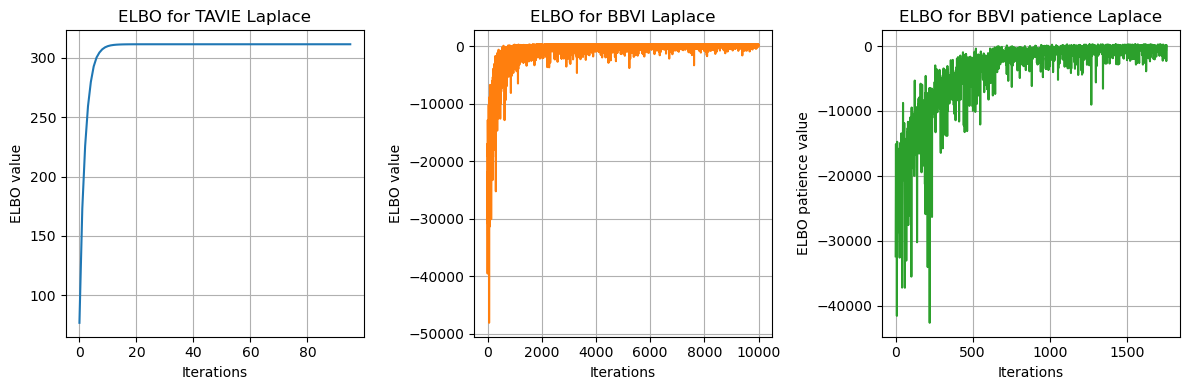

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)

# TAVIE ELBO
axes[0].plot(ELBO[6:], color='C0')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('ELBO value')
axes[0].set_title("ELBO for TAVIE Laplace")
axes[0].grid(True)

# BBVI ELBO
axes[1].plot(elbo_BBVI[6:], color='C1')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('ELBO value')
axes[1].set_title("ELBO for BBVI Laplace")
axes[1].grid(True)

# BBVI patience ELBO
axes[2].plot(elbo_BBVI_patience[6:], color='C2')
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('ELBO patience value')
axes[2].set_title("ELBO for BBVI patience Laplace")
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Convergence of TAVIE and BBVI for Student's t likelihood (SSG Type I)

In [2]:
# Simulated data
n = 10000
p = 5
tau2 = 8
nu_true = 5

# Design matrix, true regression coefficients and response
X = np.random.normal(size=(n, p))
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)
error =  np.random.standard_t(size = n, df = nu_true) * 1/np.sqrt(tau2)
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# Initialize the TAVIE model for student's-t likelihood
student_model = TAVIE_loc_scale(family="student", fit_intercept=True)
student_model.fit(X, y, nu=nu_true, verbose=False) # fit the TAVIE model
res1 = student_model.get_TAVIE_means(verbose=False) # get the TAVIE estimates
ELBO = student_model.get_elbo() # get the ELBO across iterations
# obtain the variational parameter estimates; use variational_estimates as required
variational_estimates = student_model.get_variational_estimates()
beta_est1, tau2_est1 = res1

# BBVI estimator and BBVI patience estimator
X_bbvi = np.column_stack((np.ones(n), X))
res2 = BBVI_student(X_bbvi, y, nu=nu_true)
res3 = BBVI_student_patience(X_bbvi, y, nu=nu_true)
beta_est2 = res2['beta_mean']
tau2_est2 = res2['tau2_mean']
beta_est3 = res3['beta_mean']
tau2_est3 = res3['tau2_mean']
ELBO_BBVI = res2['elbo_hist']
ELBO_BBVI_patience = res3['elbo_hist']

# displaying the TAVIE and BBVI estimates
param_names = ["beta0"] + [f"beta{i}" for i in range(1, len(beta_true))] + ["tau2"]

# Stack true and estimated values
true_vals   = np.concatenate([beta_true,  [tau2]])
tavie_vals  = np.concatenate([beta_est1,  [tau2_est1]])
bbvi_vals   = np.concatenate([beta_est2,  [tau2_est2]])
bbvi_patience_vals   = np.concatenate([beta_est3,  [tau2_est3]])

# Construct the DataFrame of results
df_estimates = pd.DataFrame(
    {
        "true":  true_vals,
        "TAVIE": tavie_vals,
        "BBVI":  bbvi_vals,
        "BBVI_patience": bbvi_patience_vals
    },
    index=param_names
)

df_estimates

Early stopping at iter 2858: no ELBO gain ≥ 0.001 for 500 iters.


,true,TAVIE,BBVI,BBVI_patience
beta0,2.320555,2.322108,2.331945,2.317063
beta1,-0.639750,-0.638997,-0.637318,-0.644972
beta2,-0.668162,-0.660781,-0.662692,-0.656202
beta3,0.975626,0.977545,0.975137,0.988152
beta4,0.292863,0.286448,0.286604,0.281348
beta5,-1.655620,-1.646758,-1.651133,-1.640047
tau2,8.000000,7.838945,8.242857,8.845769


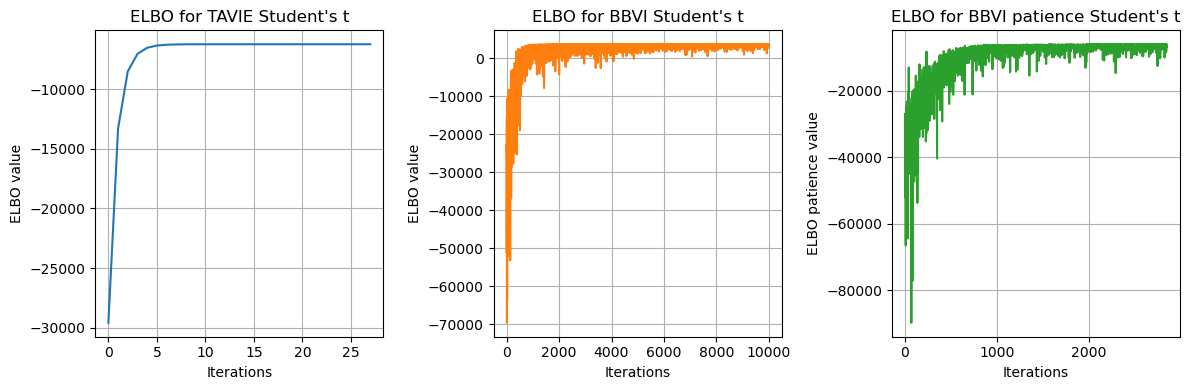

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)

# TAVIE ELBO
axes[0].plot(ELBO[6:], color='C0')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('ELBO value')
axes[0].set_title("ELBO for TAVIE Student's t")
axes[0].grid(True)

# BBVI ELBO
axes[1].plot(ELBO_BBVI[6:], color='C1')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('ELBO value')
axes[1].set_title("ELBO for BBVI Student's t")
axes[1].grid(True)

# BBVI patience ELBO
axes[2].plot(ELBO_BBVI_patience[6:], color='C2')
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('ELBO patience value')
axes[2].set_title("ELBO for BBVI patience Student's t")
axes[2].grid(True)

plt.tight_layout()
plt.show()